In [1]:
import pandas as pd
from src.eda import (
    get_corr_log_df,
    get_predict_metrics,
    calc_corr_pvalue_between_model,
    get_corr_df,
    plot_corr_by_model,
)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(font="BIZ UDPGothic")
sns.set_style("whitegrid")
plt.rcParams["font.family"] = ["BIZ UDPGothic"]

train transforms:
resize 240x240
↓
center crop 224x224
↓
random horizontal flip
↓
random affine degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.2), fill=(255, 255, 255)
↓
gaussian blur kernel_size=(5, 5), sigma=(0.1, 3)
↓
color jitter brightness=0.075, contrast=0, saturation=0.03, hue=0.03
↓
to tensor
↓


Found 18 event files in ../../log/v8/res_L/**/events.out.tfevents.*
ConvNext: r = fold
fold_1    0.644041
fold_2    0.730397
fold_3    0.642540
fold_4    0.739765
fold_5    0.664136
fold_6    0.718382
dtype: float64 ResNet: r = fold
fold_1    0.514227
fold_2    0.667773
fold_3    0.629711
fold_4    0.765710
fold_5    0.632147
fold_6    0.706125
dtype: float64 VGG: r = fold
fold_1    0.439847
fold_2    0.628207
fold_3    0.595273
fold_4    0.678377
fold_5    0.594739
fold_6    0.616630
dtype: float64 


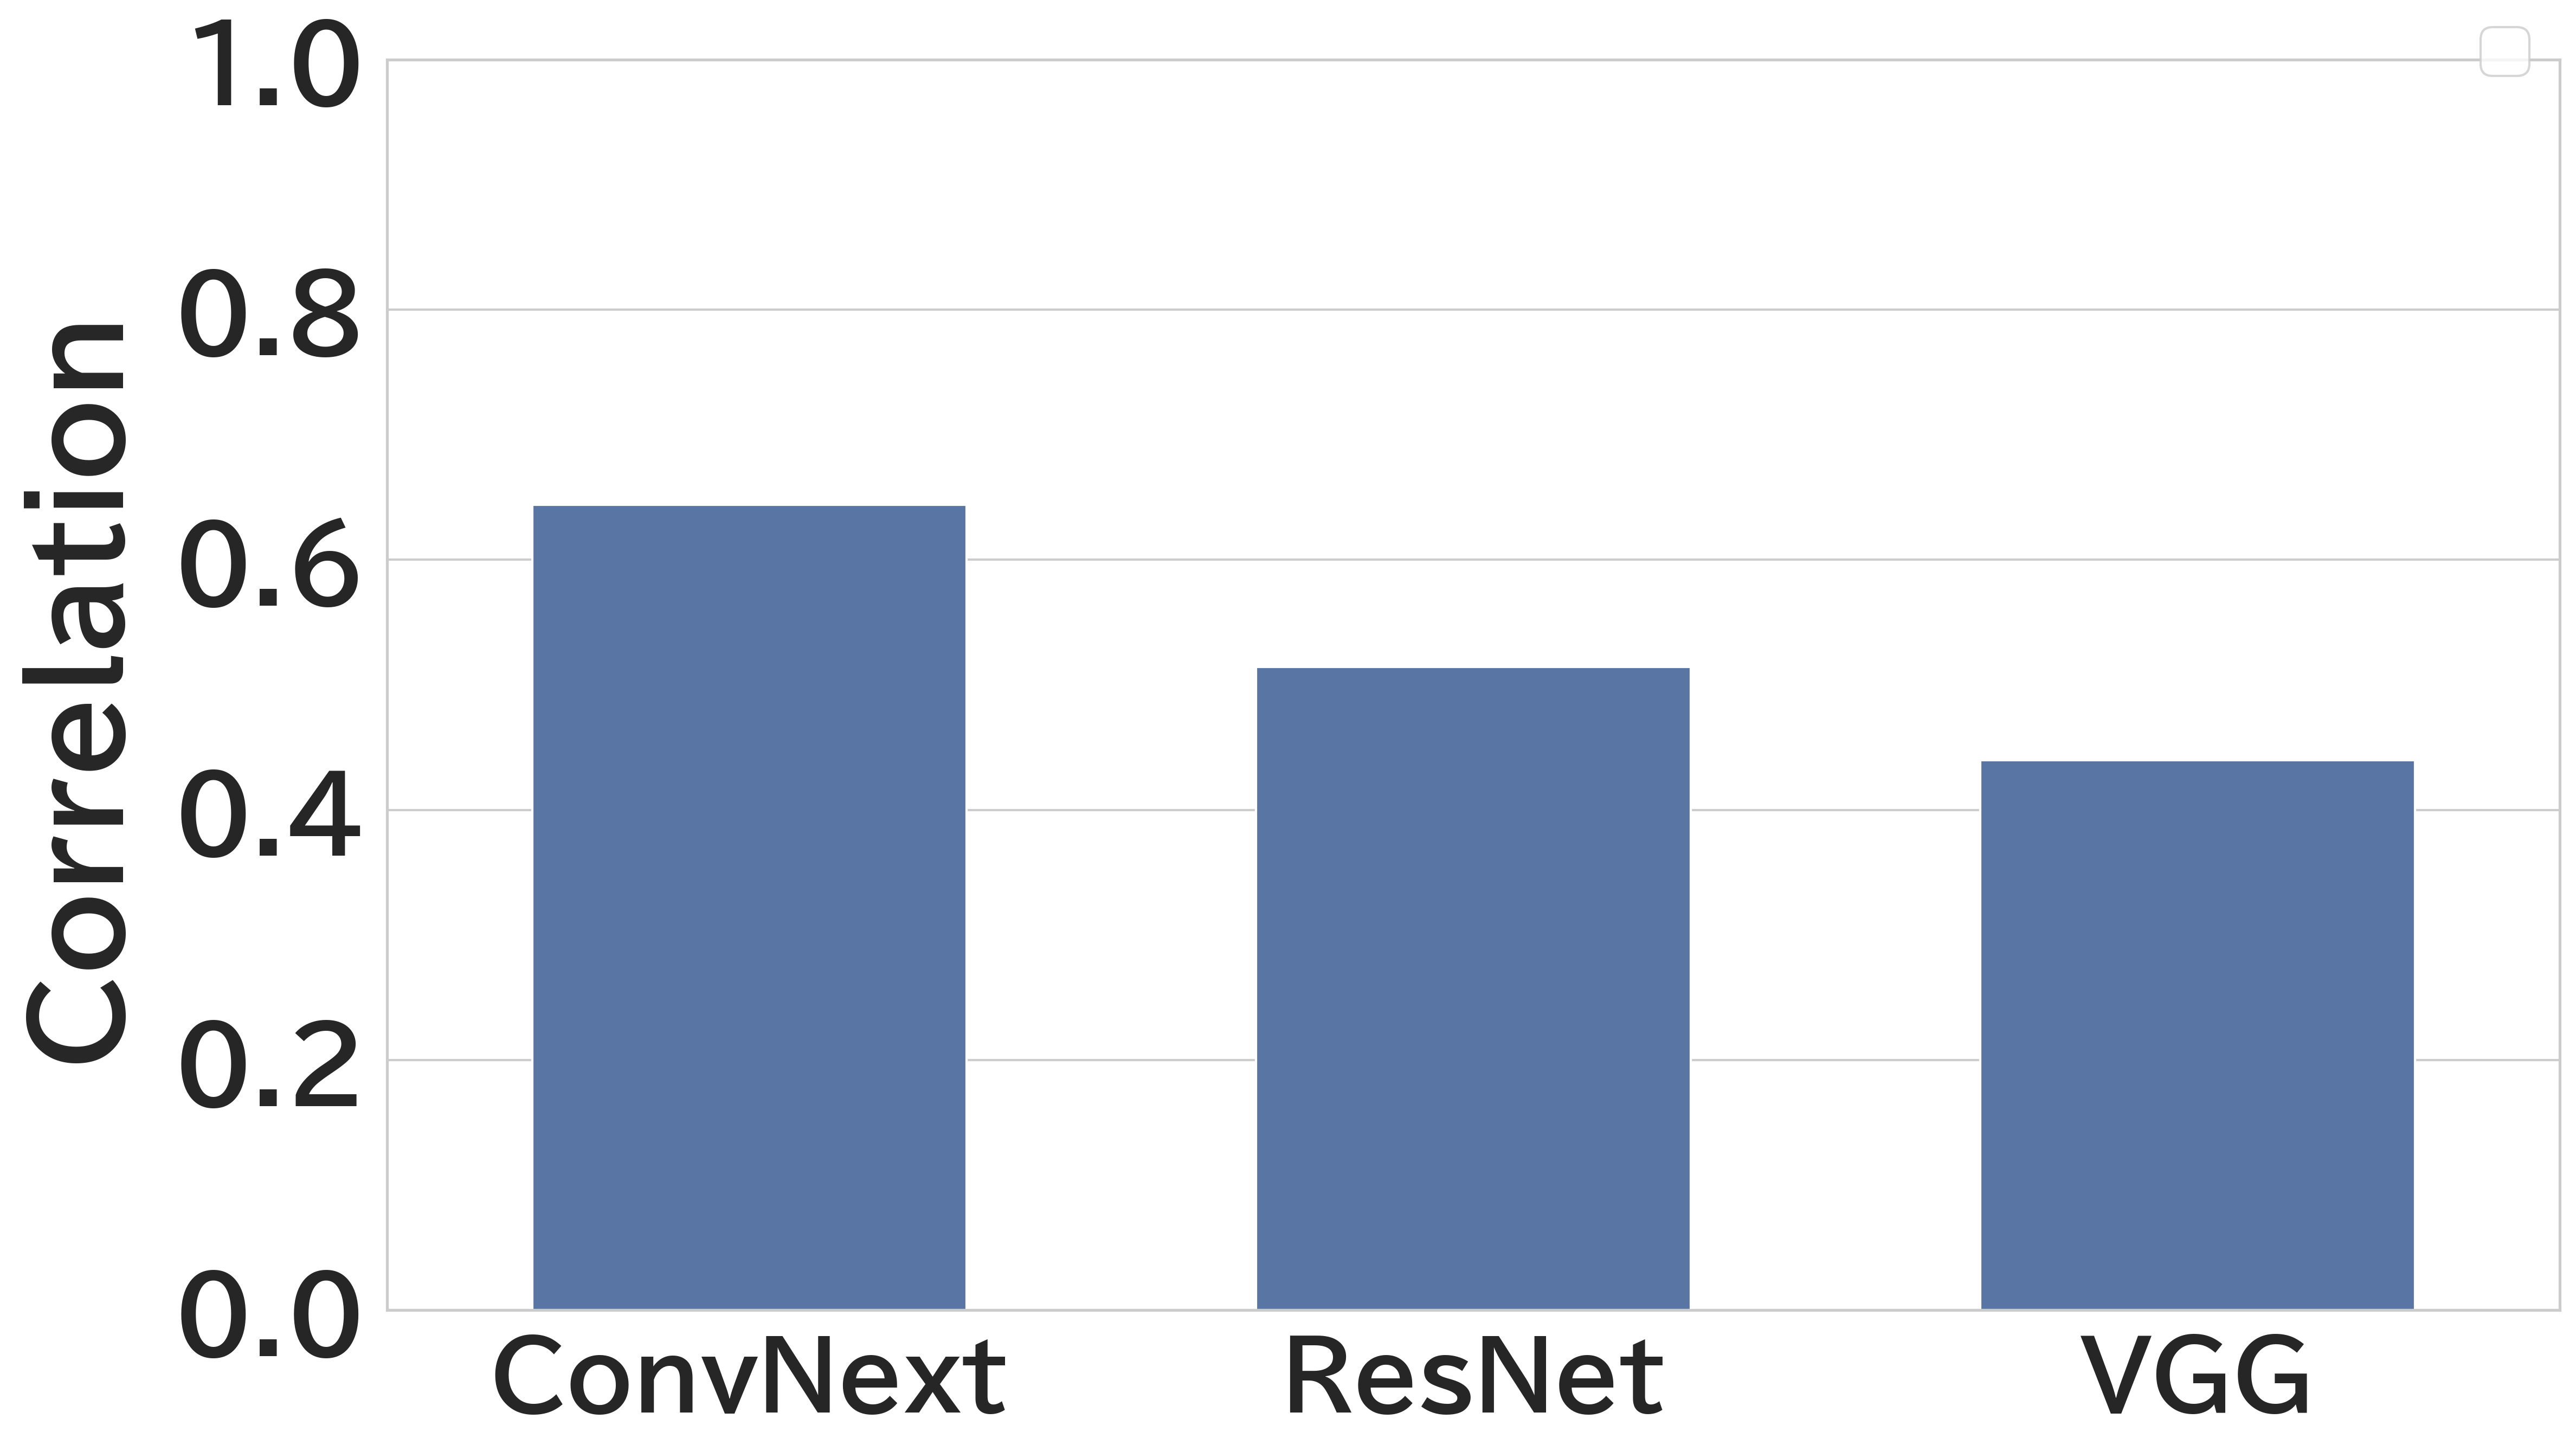

In [2]:
for VERSION in ["v8"]:
    df = get_corr_log_df(VERSION, path="" if VERSION == "v3" else "res_L")
    metrics = None
    if VERSION in ["v9", "v16"]:
        metrics = get_predict_metrics(VERSION)
        if "obesity" in metrics:
            calc_corr_pvalue_between_model(metrics)

    corr_result_df = pd.DataFrame()
    if VERSION in ["v6", "v16"]:
        for type_ in ["normal", "obesity"]:
            result = (
                metrics[type_]["actual_predicts"]
                if metrics
                else df.loc[:, slice(type_, None, None)]
                .stack(level=0)
                .reset_index(level=1, drop=True)
            )
            corr_result_df = get_corr_df(corr_result_df, result, VERSION, type_)
    else:
        result = metrics["normal"]["actual_predicts"] if metrics else df
        corr_result_df = get_corr_df(corr_result_df, result, VERSION)
    if VERSION == "v16":
        corr_result_df = pd.concat(
            [
                pd.DataFrame(
                    {
                        "type": ["normal", "obesity"],
                        "model": ["CLIP", "CLIP"],
                        "corr": [0.7618761837829687, 0.7684547336859888],
                    }
                ),
                corr_result_df,
            ]
        )
    elif VERSION == "v9":
        corr_result_df = pd.concat(
            [
                pd.DataFrame(
                    {
                        "model": ["CLIP"],
                        "corr": [0.762],
                    }
                ),
                corr_result_df,
            ]
        )
    plot_corr_by_model(corr_result_df, VERSION)